In [3]:
#Prueba por Transformada Discreta de Wavelet (DWT)

import numpy as np
import cv2
from skimage import io, color, exposure
import matplotlib.pyplot as plt
import numpy as np
import pywt
from PIL import Image

# método de fusión de imágenes basado en la transformada wavelet bidimensional

def imgfusion(Im1, Im2, ftype, wtype):
    # Se realiza la descomposición wavelet bidimensional de la primera imagen Im1 utilizando la función dwt2
    # Convertir imágenes a float y realizar la descomposición de wavelet de nivel 1
    coeffs1 = pywt.dwt2(Im1.astype(float), wtype, 'periodization')
    coeffs2 = pywt.dwt2(Im2.astype(float), wtype, 'periodization')
    
    # Extraer las sub-bandas de aproximación y detalle
    # cA1 representa la aproximación, mientras que (cH1, cV1, cD1) son las 
    # sub-bandas de detalles en las direcciones horizontal, vertical y diagonal, respectivamente.
    cA1, (cH1, cV1, cD1) = coeffs1
    cA2, (cH2, cV2, cD2) = coeffs2

    
    # Preparar matrices de coeficientes para la imagen resultante
    cA = np.zeros_like(cA1)
    cH = np.zeros_like(cH1)
    cV = np.zeros_like(cV1)
    cD = np.zeros_like(cD1)
    \
    #Se inicia un bucle que recorre cada elemento de las sub-bandas para realizar la fusión según el tipo especificado en ftype.
    # Procesar según el tipo de fusión especificado
    for i in range(cA1.shape[0]):
        for k in range(cA1.shape[1]):
            if ftype == 'MeanMean':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.mean([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.mean([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.mean([cD1[i, k], cD2[i, k]])
            # Repetir estructura similar para otros casos como 'MeanMax', 'MaxMean', etc.
        
    # Usar todas las combinaciones de fusión como se define en MATLAB
            elif ftype == 'MeanMax':
                cA[i, k] = np.mean([cA1[i, k], cA2[i, k]])
                cH[i, k] = np.max([cH1[i, k], cH2[i, k]])
                cV[i, k] = np.max([cV1[i, k], cV2[i, k]])
                cD[i, k] = np.max([cD1[i, k], cD2[i, k]])
            # Continuar con otras condiciones...

    # Reconstruir la imagen fusionada usando los coeficientes fusionados
    #Después de realizar la fusión de coeficientes, se utiliza pywt.idwt2 para 
    #reconstruir la imagen fusionada a partir de los coeficientes fusionados.
    outimage = pywt.idwt2((cA, (cH, cV, cD)), wtype, 'periodization')
    return outimage



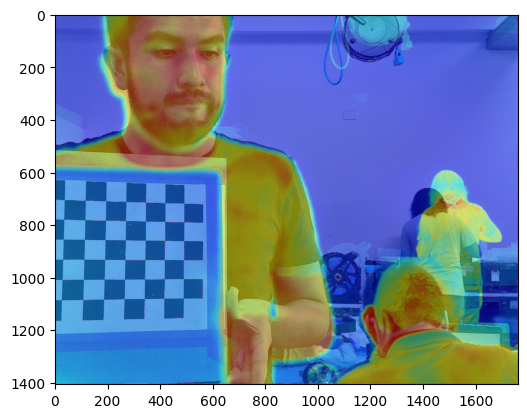

In [5]:
fusiontype = 'MeanMax'
wavetype = 'coif5'

# Cargar la imagen recortada anterior J
img1 = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
img2 = np.array(Image.open('imagen_termica17.JPG'))

# Asegurar que img2 tenga el mismo tamaño que img1
if img1.shape != img2.shape:
    img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Obtener las dimensiones de la imagen recortada
row, col, _ = img1.shape

# Fusionar las imágenes canal por canal utilizando la función imgfusion
fusedimageR = imgfusion(img1[:, :, 0], img2[:, :, 0], fusiontype, wavetype)
fusedimageG = imgfusion(img1[:, :, 1], img2[:, :, 1], fusiontype, wavetype)
fusedimageB = imgfusion(img1[:, :, 2], img2[:, :, 2], fusiontype, wavetype)

# Combinar los canales fusionados en una sola imagen
fusedimage = np.uint8(np.stack([fusedimageR, fusedimageG, fusedimageB], axis=-1))

# Guardar y mostrar la imagen fusionada, con una calidad de compresión de 100
Image.fromarray(fusedimage).save('FUSION1.jpg', quality=100)
plt.imshow(fusedimage)
plt.show()



Dimensiones de la (imagen fused_image): 1759 x 1406


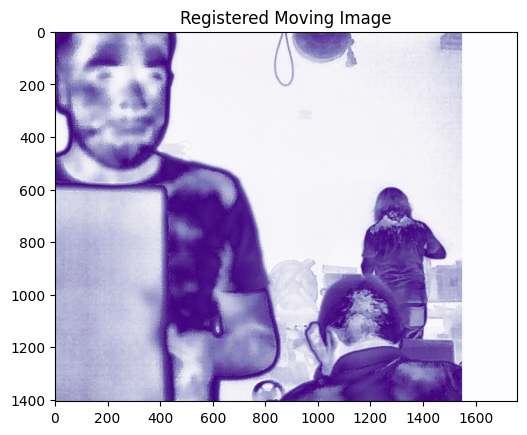

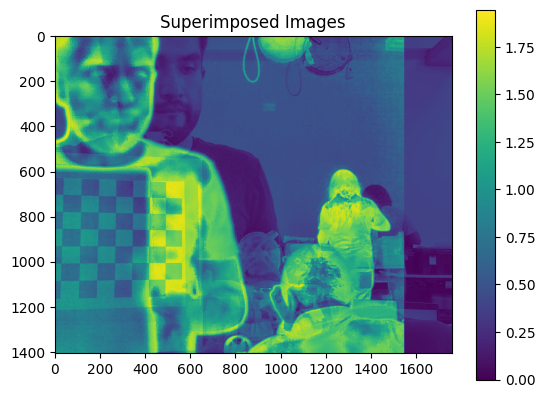

La imagen es en escala de grises (1 canal).


In [6]:
#METODO phase cross-correlation
#es una técnica útil para el registro de imágenes, es decir, para alinear dos imágenes que pueden estar 
#desplazadas, rotadas o escaladas con respecto a una a otra. No es un método de fusión en sí, sino una técnica 
#previa que puede ser muy útil para asegurarse de que las imágenes térmicas y RGB estén correctamente alineadas antes de fusionarlas.


import numpy as np
import cv2
from skimage import io, color, exposure
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

# Load and convert images to grayscale
fixed = color.rgb2gray(io.imread('imagen_recortada.jpg'))
moving = color.rgb2gray(io.imread('imagen_termica17.JPG'))

# Resize moving image to match the size of the fixed image
moving = cv2.resize(moving, (fixed.shape[1], fixed.shape[0]))

# Apply histogram equalization (Adaptive)
#es una técnica que resalta los contrastes locales en una image
moving_eq = exposure.equalize_adapthist(moving)

# Moment of the multimodal image registration process
# Perform phase cross-correlation

shift, error, diffphase = phase_cross_correlation(fixed, moving_eq)
# shift: Representa el desplazamiento entre las dos imágenes en píxeles, tanto en dirección horizontal como vertical.
# error: Este valor indica la cantidad de error asociada con el desplazamiento calculado(Un valor bajo indica un buen registro.)
# difphase: La diferencia de fase puede ser útil para entender cómo las características de las imágenes están alineadas o desalineadas.

# Apply translation to moving image
rows, cols = moving_eq.shape

translation_matrix = np.float32([[1, 0, shift[1]], [0, 1, shift[0]]])
#aplica una traslación horizontal (en el eje x) y  traslación vertical (en el eje y).
moving_registered = cv2.warpAffine(moving_eq, translation_matrix, (cols, rows))

# Display registered image
plt.figure()
plt.imshow(moving_registered, cmap='Purples')  # Registered moving image in purple
plt.title('Registered Moving Image')

# Display superimposition
plt.figure()
plt.imshow(fixed * 0.5 + 1.5 * moving_registered)  # Superimposed images with fixed in green and moving_registered in purple
plt.title('Superimposed Images')
plt.colorbar()

# Save the fused image
fused_image = fixed * 0.5 + 1.5 * moving_registered
alto2, ancho2 = fused_image.shape[:2]
print("Dimensiones de la (imagen fused_image): {} x {}".format(ancho2, alto2))
plt.imsave('FUSION2.jpg', fused_image)
#plt.imsave('FUSION1.jpg', fused_image, cmap='Greens') #funciona bien en la
plt.show()

# ANALISIS DE LOS CANALES DE UNA IMAGEN:
# Abrir la imagen
imagen = Image.open('FUSION2.jpg')

# Obtener la forma de los datos de la imagen
forma = imagen.size

# Determinar el número de canales basándose en la forma de los datos
if len(forma) == 2:
    print("La imagen es en escala de grises (1 canal).")
elif len(forma) == 3:
    # Si hay 3 valores en la forma, entonces hay múltiples canales, 
    # pero no se puede determinar si es RGB o RGBA sin más información.
    print("La imagen tiene múltiples canales, pero no se puede determinar si es RGB o RGBA sin más información.")
else:
    print("Formato de imagen no reconocido.")





In [7]:
#CODIGO para leer y fusioanr imagenes con 1 solo canal, escala de grises
#FUNCIONA
# Leer las imágenes
imageT = Image.open('FUSION2.jpg')  
imageW = Image.open('imagen_rgb4.JPG')

# Redimensionar imageT (opcional)
# imageT = imageT.resize(imageW.size)

# Obtener las dimensiones de imageT
ancho_p, alto_p = imageT.size

# Convertir las imágenes a matrices NumPy
imageT_np = np.array(imageT)
imageW_np = np.array(imageW)

# Iterar sobre los píxeles de imageT
for x in range(ancho_p):
    for y in range(alto_p):
        pixel_imageT = imageT_np[y, x]
        
        # Verificar si el píxel de imageT no es negro (valor != 0)
        if (pixel_imageT != 0).any():
            # Asignar el valor del píxel de imageT a la imagen imageW en escala de grises
            imageW_np[y+726, x+1113] = pixel_imageT


# Mostrar la imagen resultante
imagen_fusionada = Image.fromarray(imageW_np)
imagen_fusionada.show()  # Mostrar la imagen resultante
imagen_fusionada.save('imagen_fusionada.jpg')  # Guardar la imagen resultante

In [9]:
# METODO Fusión Basada en Ponderación

import numpy as np
from PIL import Image

#weight_rgb: el peso asignado a la imagen RGB en la fusión.
#weight_thermal: el peso asignado a la imagen térmica en la fusión.
#output_size: tamaño de salida opcional para las imágenes redimensionadas.

def weighted_fusion(img_rgb, img_thermal, weight_rgb, weight_thermal, output_size=None):
    # Convertir imágenes a arrays de numpy
    img_rgb = np.array(img_rgb)
    img_thermal = np.array(img_thermal)
    
    # Redimensionar imágenes si es necesario
    if output_size is not None:
        img_rgb = np.array(Image.fromarray(img_rgb).resize(output_size, Image.Resampling.LANCZOS))
        img_thermal = np.array(Image.fromarray(img_thermal).resize(output_size, Image.Resampling.LANCZOS))
    
    # Asegurar que img_thermal tenga 3 canales si es necesario
    #Si img_thermal es una imagen de un solo canal (en escala de grises), esta línea la convierte en una imagen de 
    #tres canales duplicando el canal existente en los tres canales RGB necesarios para la fusión.
    if len(img_thermal.shape) == 2:
        img_thermal = np.stack((img_thermal,)*3, axis=-1)
    
    # Normalizar las imágenes
    #Estas líneas convierten los valores de píxeles de las imágenes de enteros (de 0 a 255) a 
    #flotantes (de 0.0 a 1.0). Esto es necesario para la fusión ponderada y mantiene la precisión 
    img_rgb = img_rgb.astype(float) / 255
    img_thermal = img_thermal.astype(float) / 255
    
    # Aplicar la fusión ponderada
    #La primera línea realiza la fusión ponderada
    fused_image = (img_rgb * weight_rgb + img_thermal * weight_thermal) / (weight_rgb + weight_thermal)
    #Cada pixel de la imagen resultante es el promedio ponderado de los píxeles correspondientes en las imágenes img_rgb y img_thermal


    #La segunda línea escala los valores de nuevo al rango 0-255 y los convierte a enteros de 8 bits.
    #La función np.clip asegura que todos los valores permanezcan dentro del rango válido para imágenes
    fused_image = np.clip(fused_image * 255, 0, 255).astype(np.uint8)  # Convertir de vuelta a uint8
    

    #retorna el resultado de la fusión,
    return fused_image






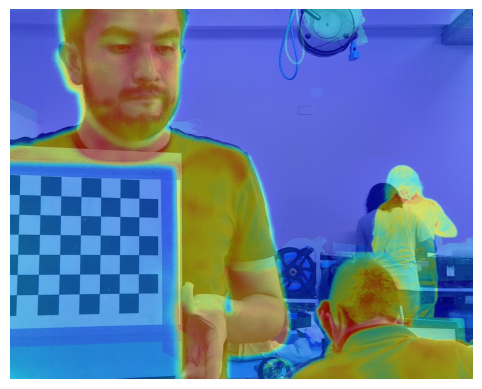

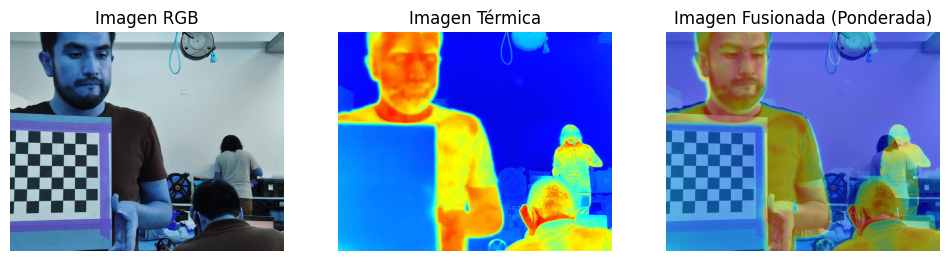

In [11]:

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


# Cargar las imágenes
rgb_image = np.array(Image.open('imagen_recortada.jpg'))
thermal_image = np.array(Image.open('imagen_termica17.jpg'))

# Ajustar el tamaño de las imágenes si es necesario
thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Definir los pesos para la fusión
weight_rgb = 0.5
weight_thermal = 0.5

# Fusionar las imágenes utilizando la función weighted_fusion
fused_image = weighted_fusion(rgb_image, thermal_image, weight_rgb, weight_thermal)

# Guardar y mostrar la imagen fusionada
Image.fromarray(fused_image).save('FUSION_Ponderada.jpg', quality=100)
plt.imshow(fused_image)
plt.axis('off')
plt.show()

# Mostrar las imágenes originales y la imagen fusionada
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('Imagen RGB')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thermal_image)
plt.title('Imagen Térmica')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_image)
plt.title('Imagen Fusionada (Ponderada)')
plt.axis('off')

plt.show()




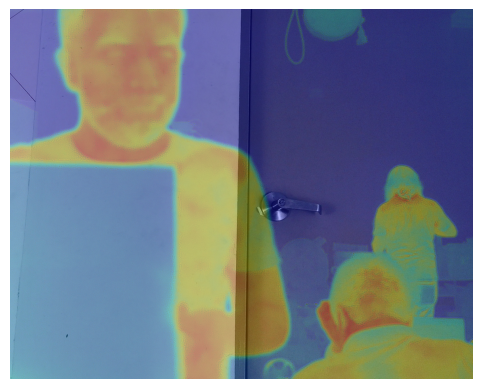

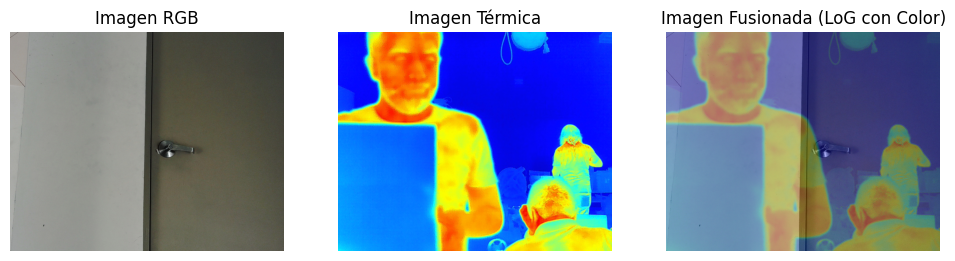

In [4]:
# METODO fusión basada en la transformada de Laplace-Gauss


import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def log_transform(image, sigma=1.0):
    # Aplicar desenfoque gaussiano
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Aplicar la transformada Laplace
    log_image = cv2.Laplacian(blurred, cv2.CV_64F)
    return log_image

def fuse_images_log_color(rgb_image, thermal_image, sigma=1.0):
    # Convertir la imagen térmica a escala de grises
    thermal_gray = cv2.cvtColor(thermal_image, cv2.COLOR_RGB2GRAY)
    
    # Aplicar la transformada LoG a la imagen térmica en escala de grises
    log_thermal = log_transform(thermal_gray, sigma)
    
    # Normalizar la transformada LoG al rango [0, 1]
    log_thermal_normalized = cv2.normalize(log_thermal, None, 0, 1, cv2.NORM_MINMAX)
    
    # Redimensionar la imagen térmica a las dimensiones de la imagen RGB si es necesario
    if rgb_image.shape[:2] != thermal_image.shape[:2]:
        thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))
    
    # Fusionar las imágenes utilizando una máscara basada en la transformada LoG
    fused_image = cv2.addWeighted(rgb_image.astype(np.float64), 1.0, 
                                  (thermal_image * log_thermal_normalized[:,:,np.newaxis]).astype(np.float64), 1.0, 0)
    
    # Escalar la imagen fusionada al rango de 0 a 255 y convertir a uint8
    fused_image = cv2.normalize(fused_image, None, 0, 255, cv2.NORM_MINMAX)
    fused_image = np.uint8(fused_image)
    
    return fused_image

# Cargar las imágenes
rgb_image = np.array(Image.open('imagen_recortada.jpg'))
thermal_image = np.array(Image.open('imagen_termica17.jpg'))


# Ajustar el tamaño de las imágenes si es necesario
# Asegurar que las imágenes tengan el mismo tamaño
thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))
# (asegúrate de que tengan las mismas dimensiones)


# Fusionar las imágenes utilizando la transformada LoG y conservación del color
fused_image = fuse_images_log_color(rgb_image, thermal_image)

# Guardar y mostrar la imagen fusionada
Image.fromarray(fused_image).save('FUSION_Log_Color.jpg', quality=100)
plt.imshow(fused_image)
plt.axis('off')
plt.show()

# Mostrar las imágenes originales y la imagen fusionada
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(rgb_image)
plt.title('Imagen RGB')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(thermal_image)
plt.title('Imagen Térmica')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(fused_image)
plt.title('Imagen Fusionada (LoG con Color)')
plt.axis('off')

plt.show()

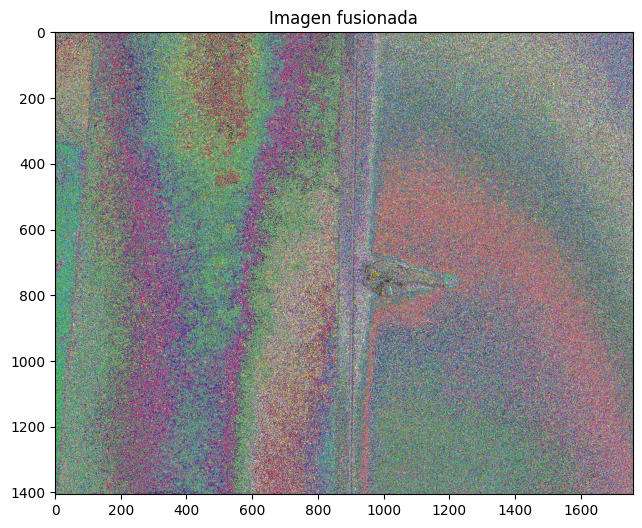

In [6]:
#  Histogram-based fusion

import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_based_fusion(img1, img2):
    # Calcular los histogramas de cada canal de color de la imagen RGB (img1)
    hist_img1_R = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist_img1_G = cv2.calcHist([img1], [1], None, [256], [0, 256])
    hist_img1_B = cv2.calcHist([img1], [2], None, [256], [0, 256])

    # Calcular el histograma de la imagen térmica (img2)
    # Si la imagen térmica tiene solo un canal, calcula su histograma directamente
    if len(img2.shape) == 2:
        hist_img2 = cv2.calcHist([img2], [0], None, [256], [0, 256])
    else:
        # Si la imagen térmica tiene tres canales, calcula los histogramas de cada canal
        hist_img2_R = cv2.calcHist([img2], [0], None, [256], [0, 256])
        hist_img2_G = cv2.calcHist([img2], [1], None, [256], [0, 256])
        hist_img2_B = cv2.calcHist([img2], [2], None, [256], [0, 256])
        # Promedia los histogramas de los tres canales para obtener un histograma único
        hist_img2 = (hist_img2_R + hist_img2_G + hist_img2_B) / 3

    # Combinar los histogramas ponderados de cada canal
    fused_hist_R = 0.1 * hist_img1_R + 0.9 * hist_img2
    fused_hist_G = 0.1 * hist_img1_G + 0.9 * hist_img2
    fused_hist_B = 0.1 * hist_img1_B + 0.9 * hist_img2

    # Aplicar los histogramas ponderados para obtener la imagen fusionada
    #Se aplica la transformación de tablas de búsqueda (LUT) a cada canal de color de 
    #img1 utilizando los histogramas ponderados para obtener los canales fusionados
    fused_img_R = cv2.LUT(img1[:, :, 0], np.uint8(fused_hist_R))
    fused_img_G = cv2.LUT(img1[:, :, 1], np.uint8(fused_hist_G))
    fused_img_B = cv2.LUT(img1[:, :, 2], np.uint8(fused_hist_B))

    # Fusionar los canales de color en una sola imagen utilizando cv2.merge
    fused_img = cv2.merge([fused_img_R, fused_img_G, fused_img_B])

    return fused_img

# Cargar las imágenes
img1 = cv2.imread('imagen_recortada.jpg')
img2 = cv2.imread('imagen_termica4.jpg')

# Asegurar que las imágenes tengan el mismo tamaño
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Realizar la fusión de imágenes basada en histograma
fused_image = histogram_based_fusion(img1, img2)

# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))

#plt.subplot(1, 3, 1)
#plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
#plt.title('Imagen 1')

#plt.subplot(1, 3, 2)
#plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
#plt.title('Imagen 2')

#plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(fused_image, cv2.COLOR_BGR2RGB))
plt.title('Imagen fusionada')

plt.show()


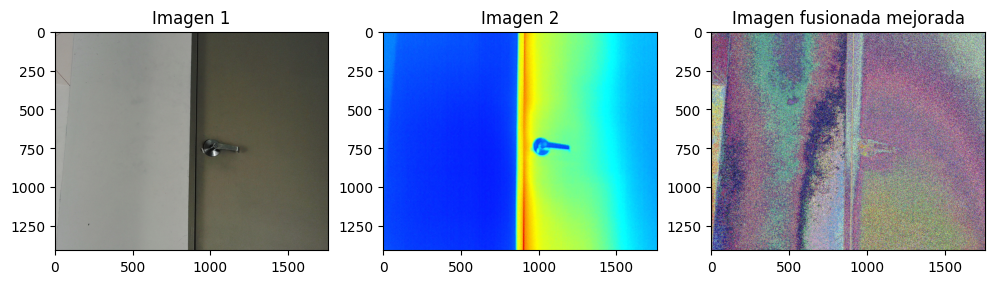

In [140]:
#METODO 
# PARTE 2
# MEJORA

import cv2
import numpy as np
import matplotlib.pyplot as plt

def histogram_based_fusion(img1, img2):
    # Calcular los histogramas de cada canal de color de ambas imágenes
    hist_img1_R = cv2.calcHist([img1], [0], None, [256], [0, 256])
    hist_img1_G = cv2.calcHist([img1], [1], None, [256], [0, 256])
    hist_img1_B = cv2.calcHist([img1], [2], None, [256], [0, 256])

    hist_img2_R = cv2.calcHist([img2], [0], None, [256], [0, 256])
    hist_img2_G = cv2.calcHist([img2], [1], None, [256], [0, 256])
    hist_img2_B = cv2.calcHist([img2], [2], None, [256], [0, 256])

    # Ajustar los parámetros de ponderación
    alpha = 0.3  # Ajusta este valor para cambiar la influencia de la imagen térmica
    beta = 1 - alpha

    # Combinar los histogramas de cada canal
    fused_hist_R = alpha * hist_img1_R + beta * hist_img2_R
    fused_hist_G = alpha * hist_img1_G + beta * hist_img2_G
    fused_hist_B = alpha * hist_img1_B + beta * hist_img2_B

    # Aplicar los histogramas ponderados para obtener la imagen fusionada
    fused_img_R = cv2.LUT(img1[:, :, 0], np.uint8(fused_hist_R))
    fused_img_G = cv2.LUT(img1[:, :, 1], np.uint8(fused_hist_G))
    fused_img_B = cv2.LUT(img1[:, :, 2], np.uint8(fused_hist_B))

    fused_img = cv2.merge([fused_img_R, fused_img_G, fused_img_B])

    return fused_img

# Función para ajustar el contraste y mejorar los bordes de la imagen final
def adjust_contrast_and_edges(img):
    # Aplicar mejora del contraste utilizando la ecualización del histograma
    img_eq = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_eq[:, :, 0] = cv2.equalizeHist(img_eq[:, :, 0])
    img_eq = cv2.cvtColor(img_eq, cv2.COLOR_YUV2BGR)
    
    # Aplicar mejora de bordes utilizando un filtro bilateral
    img_bilateral = cv2.bilateralFilter(img_eq, 9, 75, 75)
    
    return img_bilateral

# Cargar las imágenes
img1 = cv2.imread('imagen_recortada.jpg')
img2 = cv2.imread('imagen_termica4.jpg')

# Asegurar que las imágenes tengan el mismo tamaño
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Realizar la fusión de imágenes basada en histograma
fused_image = histogram_based_fusion(img1, img2)

# Ajustar el contraste y mejorar los bordes de la imagen fusionada
fused_image_processed = adjust_contrast_and_edges(fused_image)

# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Imagen 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Imagen 2')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(fused_image_processed, cv2.COLOR_BGR2RGB))
plt.title('Imagen fusionada mejorada')

plt.show()



Número de keypoints en keypoints1: 309
Número de keypoints en keypoints2: 61


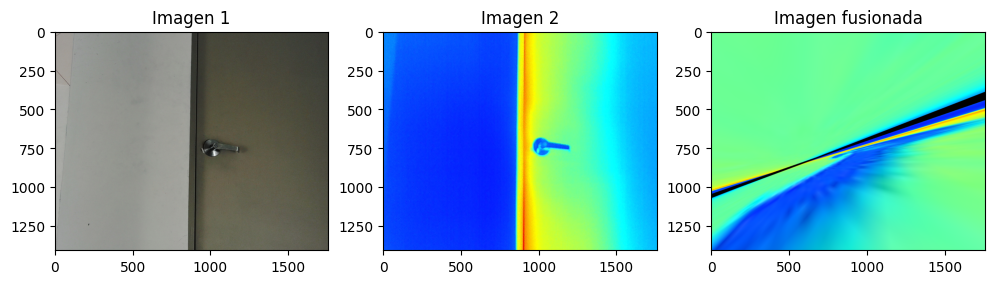

In [125]:
# PRUeba METODO BRISK Y HOMOGRAFIA:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def fusion_brisk_homography(img1, img2):
    # Convertir las imágenes a escala de grises
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Inicializar el detector BRISK
    brisk = cv2.BRISK_create()
    
    # Encontrar puntos clave y descriptores en ambas imágenes
    keypoints1, descriptors1 = brisk.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = brisk.detectAndCompute(gray2, None)

    # Contar el número de keypoints en keypoints1 y keypoints2
    num_keypoints1 = len(keypoints1)
    num_keypoints2 = len(keypoints2)

    print("Número de keypoints en keypoints1:", num_keypoints1)
    print("Número de keypoints en keypoints2:", num_keypoints2)

    
    # Inicializar el matcher de correspondencias de fuerza bruta
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
    # Encontrar las correspondencias entre los descriptores de ambas imágenes
    matches = bf.match(descriptors1, descriptors2)
    
    # Ordenar las correspondencias por distancia
    matches = sorted(matches, key=lambda x: x.distance)
    
    # Extraer las coordenadas de los puntos clave coincidentes
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    # Calcular la homografía que mapea img2 a img1
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
    # Aplicar la homografía para fusionar las imágenes
    fused_image = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
    
    return fused_image

# Cargar las imágenes
img1 = cv2.imread('imagen_recortada.jpg')
img2 = cv2.imread('imagen_termica4.jpg')

# Asegurar que las imágenes tengan el mismo tamaño
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Realizar la fusión utilizando BRISK y homografía
fused_image = fusion_brisk_homography(img1, img2)

# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Imagen 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Imagen 2')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(fused_image, cv2.COLOR_BGR2RGB))
plt.title('Imagen fusionada')

plt.show()



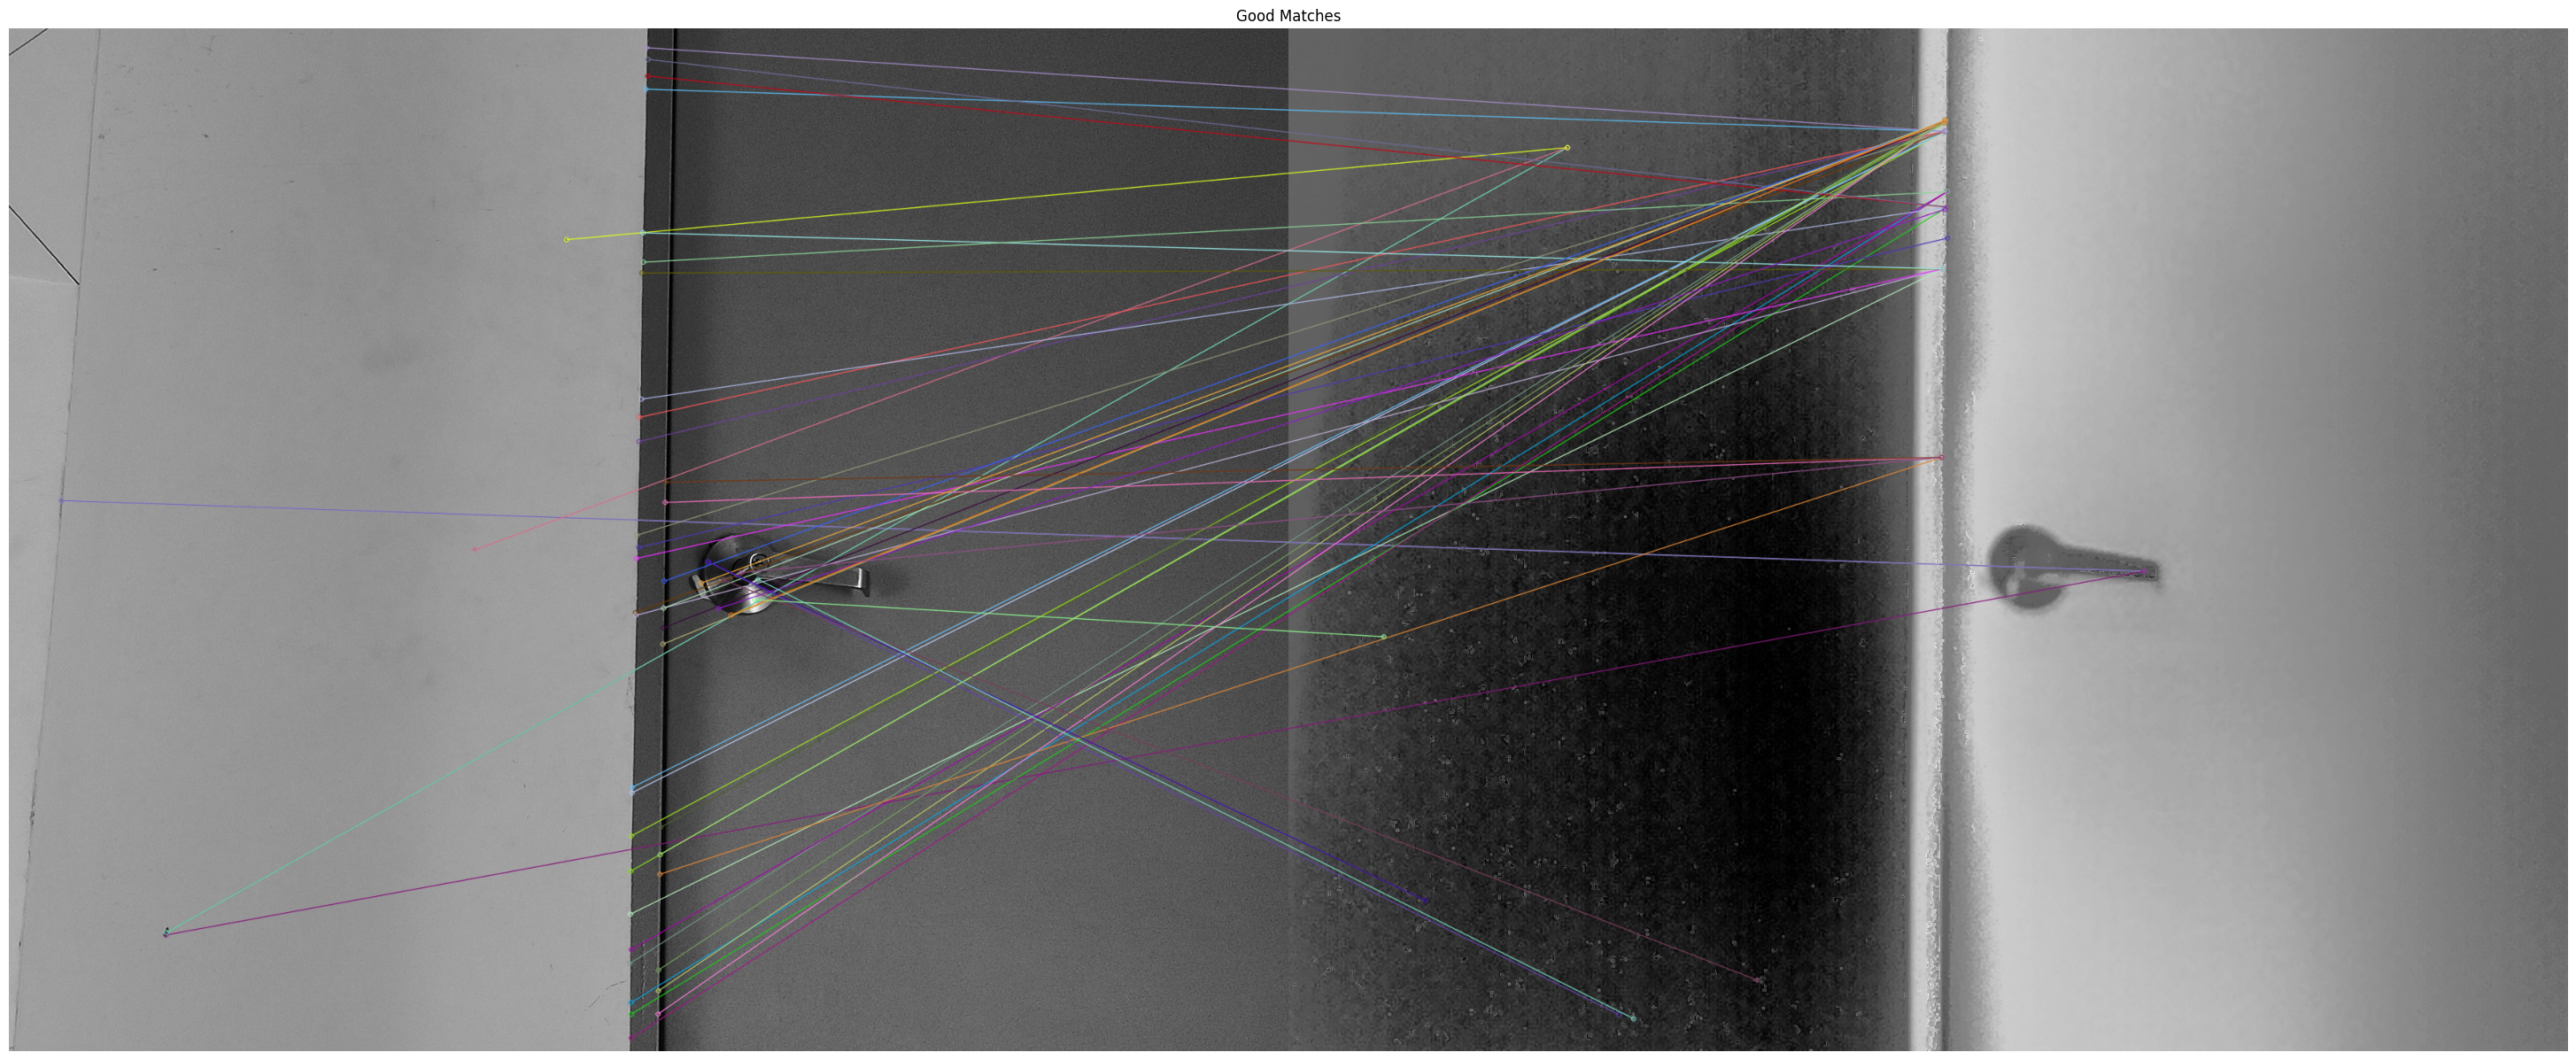

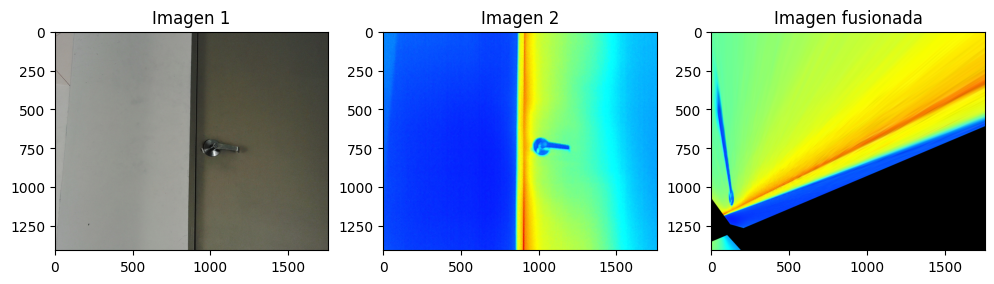

In [1]:
# Test SIFT METHOD (Scale-Invariant Feature Transform) AND HOMOGRAPHY:

import cv2
import numpy as np
import matplotlib.pyplot as plt

def pre_process_image(img):
    # Mejorar el contraste mediante la ecualización del histograma
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_eq = cv2.equalizeHist(img_gray)

    # Detección de bordes usando Canny
    img_edges = cv2.Canny(img_eq, 100, 200)

    # Combina la imagen ecualizada con los bordes para resaltar los bordes
    img_preprocessed = cv2.addWeighted(img_eq, 0.8, img_edges, 0.2, 0)
    return img_preprocessed

def fusion_sift_homography(img1, img2):
    # Pre-procesar la segunda imagen (térmica)
    img2_preprocessed = pre_process_image(img2)

    # Convertir la primera imagen a escala de grises
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    
    # Usar la imagen preprocesada como la segunda imagen en escala de grises
    gray2 = img2_preprocessed
    
    # Inicializar el detector SIFT
    sift = cv2.SIFT_create()
    
    
    # Encontrar puntos clave y descriptores en ambas imágenes
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)
    

    # Inicializar el matcher de correspondencias de fuerza bruta
    bf = cv2.BFMatcher()
    

    # Encontrar las correspondencias entre los descriptores de ambas imágenes
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    

    # Aplicar el filtro de razón de Lowe
    good_matches = []
    for m, n in matches:
        if m.distance < 0.85 * n.distance:
            good_matches.append(m)
    

    # Dibujar buenos emparejamientos
    result_image = cv2.drawMatches(gray1, keypoints1, gray2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    fig, ax = plt.subplots(figsize=(40, 15))
    ax.imshow(result_image, cmap='gray')
    ax.set_title('Good Matches')
    ax.axis('off')
    plt.show()


    # Extraer las coordenadas de los puntos clave coincidentes
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Calcular la homografía que mapea img2 a img1
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
    
    # Aplicar la homografía para fusionar las imágenes
    fused_image = cv2.warpPerspective(img2, H, (img1.shape[1], img1.shape[0]))
    
    return fused_image

# Cargar las imágenes
img1 = cv2.imread('imagen_recortada.jpg')
img2 = cv2.imread('imagen_termica4.jpg')

# Asegurar que las imágenes tengan el mismo tamaño
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

# Realizar la fusión utilizando SIFT y homografía
fused_image = fusion_sift_homography(img1, img2)

# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Imagen 1')
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Imagen 2')
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(fused_image, cv2.COLOR_BGR2RGB))
plt.title('Imagen fusionada')
plt.show()



In [ ]:
# Analicis de mejoras por partes: PREPROSESAMIENTO

import cv2
import numpy as np


#Filtro 
def pre_process_image(img):
    # Convertir la imagen a escala de grises
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Mejorar el contraste mediante la ecualización del histograma
    img_eq = cv2.equalizeHist(img_gray)

    # Detección de bordes usando Canny
    img_edges_canny = cv2.Canny(img_eq, 50, 150)  # Ajustar los umbrales según sea necesario

    # Detección de bordes usando Sobel
    sobelx = cv2.Sobel(img_eq, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(img_eq, cv2.CV_64F, 0, 1, ksize=5)
    img_edges_sobel = cv2.magnitude(sobelx, sobely)

    # Normalizar el resultado de Sobel para que esté en el mismo rango de intensidades que Canny
    cv2.normalize(img_edges_sobel, img_edges_sobel, 0, 255, cv2.NORM_MINMAX)
    img_edges_sobel = img_edges_sobel.astype(np.uint8)

    # Combinar Canny y Sobel para obtener una imagen de bordes más robusta
    img_edges_combined = cv2.addWeighted(img_edges_canny, 0.5, img_edges_sobel, 0.5, 0)

    # Combinar la imagen ecualizada con los bordes combinados para resaltar los bordes
    img_preprocessed = cv2.addWeighted(img_eq, 0.8, img_edges_combined, 0.2, 0)
    
    return img_preprocessed





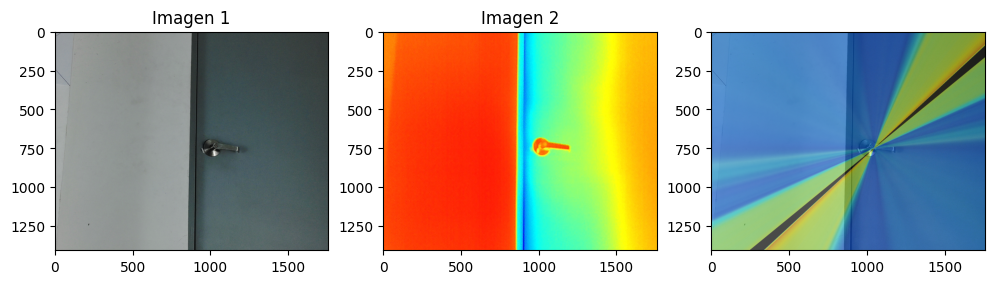

In [109]:

# Metodo segundo método, denominado ECC

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def fusion_ecc_orb(rgb_img, thermal_img):
    # Convertir las imágenes a escala de grises
    gray_rgb = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    gray_thermal = cv2.cvtColor(thermal_img, cv2.COLOR_RGB2GRAY)
    
    # Inicializar el detector ORB
    orb = cv2.ORB_create()
    
    # Detectar keypoints y calcular descriptores en ambas imágenes
    keypoints1, descriptors1 = orb.detectAndCompute(gray_thermal, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray_rgb, None)
    
    # Encontrar la homografía entre las imágenes térmica y RGB
    matches = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True).match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    
    homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Aplicar la homografía a la imagen térmica
    rows, cols = gray_rgb.shape
    aligned_thermal = cv2.warpPerspective(thermal_img, homography, (cols, rows))
    
    # Combinar las imágenes alineadas y la imagen RGB original
    fused_image = cv2.addWeighted(rgb_img, 0.5, aligned_thermal, 0.5, 0)
    
    return fused_image

# Cargar la imagen RGB recortada anteriormente
rgb_image = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
thermal_image = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que la imagen térmica tenga el mismo tamaño que la imagen RGB
if rgb_image.shape != thermal_image.shape:
    thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Fusionar las imágenes utilizando el método ECC con el detector ORB
fused_image_ecc_orb = fusion_ecc_orb(rgb_image, thermal_image)

# Guardar y mostrar la imagen fusionada
# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Imagen 1')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.title('Imagen 2')

plt.subplot(1, 3, 3)
Image.fromarray(fused_image_ecc_orb).save('FUSION_ECC_ORB.jpg', quality=100)
plt.imshow(fused_image_ecc_orb)


plt.show()








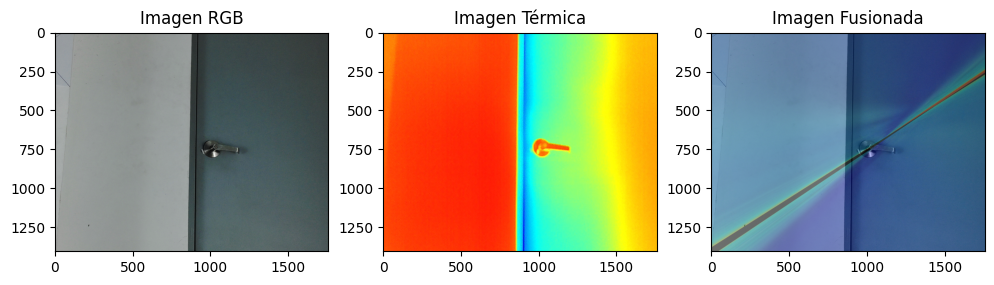

In [4]:
# ECC, parte2


import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def enhance_image(image):
    # Aplicar un filtro bilateral para reducir el ruido mientras se conserva la nitidez
    enhanced_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
    return enhanced_image

def fusion_ecc_orb(rgb_img, thermal_img):
    # Preprocesamiento: mejorar ambas imágenes
    enhanced_rgb = enhance_image(rgb_img)
    enhanced_thermal = enhance_image(thermal_img)

    # Convertir las imágenes a escala de grises
    gray_rgb = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2GRAY)
    gray_thermal = cv2.cvtColor(enhanced_thermal, cv2.COLOR_RGB2GRAY)
    
    # Inicializar el detector ORB
    orb = cv2.ORB_create(nfeatures=5000)  # Aumentar el número de características detectadas
    
    # Detectar keypoints y calcular descriptores en ambas imágenes
    keypoints1, descriptors1 = orb.detectAndCompute(gray_thermal, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray_rgb, None)
    
    # Encontrar la homografía entre las imágenes térmica y RGB
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    matches = sorted(matches, key=lambda x: x.distance)
    
    if len(matches) > 4:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Aplicar la homografía a la imagen térmica
        rows, cols = gray_rgb.shape
        aligned_thermal = cv2.warpPerspective(thermal_img, homography, (cols, rows))
        
        # Combinar las imágenes alineadas y la imagen RGB original
        fused_image = cv2.addWeighted(rgb_img, 0.7, aligned_thermal, 0.3, 0)  # Ajustar pesos según sea necesario
        
        return fused_image
    else:
        print("No se encontraron suficientes correspondencias.")
        return None

# Cargar la imagen RGB recortada anteriormente
rgb_image = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
thermal_image = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que la imagen térmica tenga el mismo tamaño que la imagen RGB
if rgb_image.shape != thermal_image.shape:
    thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Fusionar las imágenes utilizando el método ECC con el detector ORB
fused_image_ecc_orb = fusion_ecc_orb(rgb_image, thermal_image)

# Guardar y mostrar la imagen fusionada
if fused_image_ecc_orb is not None:
    # Mostrar las imágenes con Matplotlib
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen RGB')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Térmica')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(fused_image_ecc_orb, cv2.COLOR_BGR2RGB))
    plt.title('Imagen Fusionada')
    Image.fromarray(fused_image_ecc_orb).save('FUSION_ECC_ORB.jpg', quality=100)

    plt.show()
else:
    print("Fusión no exitosa debido a insuficientes correspondencias.")



In [32]:
# método de fusión de imágenes basado en B-SPLINE con la métrica de información mutua normalizada (NMI)

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pyelastix




def fusion_bspline(rgb_img, thermal_img):
    # Convertir las imágenes a formato adecuado para pyelastix (uint8)
    rgb_img_uint8 = (rgb_img * 255).astype(np.uint8)
    thermal_img_uint8 = (thermal_img * 255).astype(np.uint8)
    
    # Crear un objeto Parameters para definir los parámetros del registro
    params = pyelastix.Parameters()
    params.FixedInternalImagePixelType = 'float'
    params.MovingInternalImagePixelType = 'float'
    params.FixedImageDimension = '2'
    params.MovingImageDimension = '2'
    params.UseDirectionCosines = 'true'
    params.Registration = 'MultiResolutionRegistration'
    params.Interpolator = 'BSplineInterpolator'
    params.ResampleInterpolator = 'FinalBSplineInterpolator'
    params.FinalBSplineInterpolationOrder = '3'
    params.Metric = 'AdvancedMattesMutualInformation'
    params.Transform = 'BSplineTransform'
    params.Metric0Weight = '1'
    params.BSplineTransformSplineOrder = '3'
    params.FinalGridSpacingInPhysicalUnits = '8'
    params.NumberOfResolutions = '3'
    params.MaximumNumberOfIterations = '250'
    params.NumberOfSpatialSamples = '2048'
    params.NumberOfThreads = '1'
    params.WriteResultImage = 'false'
    
    # Realizar el registro utilizando pyelastix
    registered_rgb_img_uint8, _ = pyelastix.register(thermal_img_uint8, rgb_img_uint8, params=params)
    
    # Convertir la imagen registrada de nuevo a punto flotante en el rango [0, 1]
    registered_rgb_img = registered_rgb_img_uint8.astype(np.float32) / 255.0
    
    return registered_rgb_img

# Cargar la imagen RGB recortada anteriormente
rgb_image = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
thermal_image = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que la imagen térmica tenga el mismo tamaño que la imagen RGB
if rgb_image.shape != thermal_image.shape:
    thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Fusionar las imágenes utilizando el método B-SPLINE con NMI
fused_image_bspline = fusion_bspline(rgb_image, thermal_image)

# Mostrar la imagen fusionada
plt.imshow(fused_image_bspline)
plt.axis('off')
plt.show()


#---------------------------------------------------------------
#Otra forma de evaluar el mismo metodo

def fusion_bspline(rgb_img, thermal_img):
    # Convertir las imágenes a formato adecuado para pyelastix (uint8)
    rgb_img_uint8 = (rgb_img * 255).astype(np.uint8)
    thermal_img_uint8 = (thermal_img * 255).astype(np.uint8)
    
    # Establecer los parámetros de elastix para la transformación B-SPLINE
    parameters_bspline = pyelastix.get_default_params('bspline', fixed_image=thermal_img_uint8, moving_image=rgb_img_uint8)
    
    # Realizar el registro utilizando pyelastix
    registered_rgb_img_uint8 = pyelastix.register_images(parameters_bspline, thermal_img_uint8, rgb_img_uint8)
    
    # Convertir la imagen registrada de nuevo a punto flotante en el rango [0, 1]
    registered_rgb_img = registered_rgb_img_uint8.astype(np.float32) / 255.0
    
    return registered_rgb_img

# Cargar la imagen RGB recortada anteriormente
rgb_image = np.array(Image.open('imagen_recortada.jpg'))

# Cargar la imagen térmica
thermal_image = np.array(Image.open('imagen_termica4.JPG'))

# Asegurar que la imagen térmica tenga el mismo tamaño que la imagen RGB
if rgb_image.shape != thermal_image.shape:
    thermal_image = cv2.resize(thermal_image, (rgb_image.shape[1], rgb_image.shape[0]))

# Fusionar las imágenes utilizando el método B-SPLINE con NMI
fused_image_bspline = fusion_bspline(rgb_image, thermal_image)

# Mostrar la imagen fusionada
plt.imshow(fused_image_bspline)
plt.axis('off')
plt.show()









RuntimeError: Could not find Elastix executable. Download Elastix from http://elastix.isi.uu.nl/. Pyelastix looks for the exe in a series of common locations. Set ELASTIX_PATH if necessary.

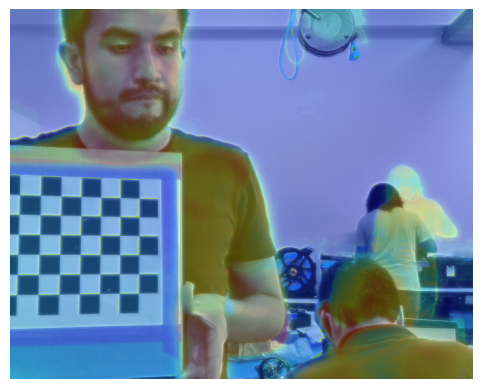

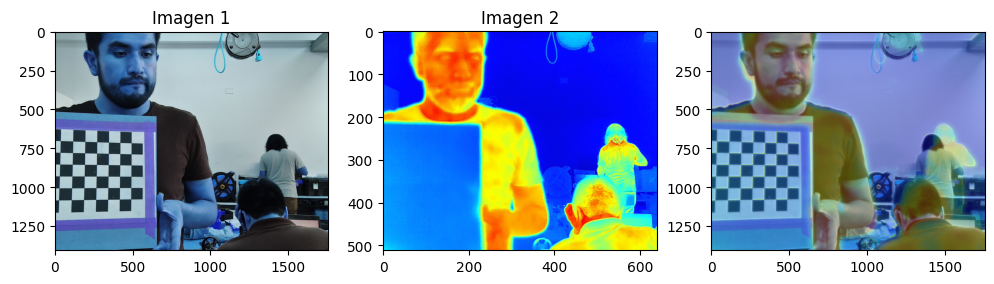

In [8]:
# Metodo Fusión basada en pirámide gaussiana:



import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#Crea una pirámide gaussiana de la imagen, reduciendo la resolución de la imagen en cada nivel.
def gaussian_pyramid(image, levels):
    pyramid = [image]
    for _ in range(levels - 1):
        image = cv2.pyrDown(image) #Reduce la imagen a la mitad de su tamaño original usando un filtro gaussiano
        pyramid.append(image) #Añade la imagen reducida a la pirámide.
    return pyramid



#Crea una pirámide laplaciana a partir de una pirámide gaussiana.
def laplacian_pyramid(image, levels):
    gaussian = gaussian_pyramid(image, levels)
    pyramid = [gaussian[-1]] #Inicia la pirámide laplaciana con el nivel más bajo de la pirámide gaussiana.
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian[i])
        if expanded.shape[:2] != gaussian[i - 1].shape[:2]:
            expanded = cv2.resize(expanded, (gaussian[i - 1].shape[1], gaussian[i - 1].shape[0]))
        laplacian = cv2.subtract(gaussian[i - 1], expanded)
        pyramid.append(laplacian) #Añade la imagen laplaciana a la pirámide.
    return pyramid #Devuelve la pirámide laplaciana completa.



#Reconstruye la imagen original a partir de una pirámide laplaciana.
def reconstruct_from_pyramid(pyramid):
    image = pyramid[0] #Inicia con el nivel más bajo de la pirámide.
    for level in pyramid[1:]: # Itera sobre los niveles restantes de la pirámide.
        image = cv2.pyrUp(image)
        if image.shape[:2] != level.shape[:2]:
            image = cv2.resize(image, (level.shape[1], level.shape[0]))
        image = cv2.add(image, level) #Añade el nivel actual a la imagen expandida
    return image #Devuelve la imagen reconstruida.



#Fusiona dos imágenes utilizando pirámides laplacianas y gaussianas.
def gaussian_pyramid_fusion(image1, image2, levels):
   
    # Generate Laplacian pyramids for both images
    laplacian1 = laplacian_pyramid(image1, levels)
    laplacian2 = laplacian_pyramid(image2, levels)
    
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        image2 = cv2.resize(image2, (image1.shape[1], image1.shape[0]))
    
    # Generate Gaussian pyramid for a mask (average of two images)
    mask = np.ones_like(image1)
    mask1 = gaussian_pyramid(mask, levels)
    mask2 = gaussian_pyramid(mask, levels)
    
    # Resize Laplacian pyramids and masks to match image dimensions
    #Ajusta el tamaño de los niveles de las pirámides y máscaras si es necesario.
    for i in range(len(laplacian1)):
        if laplacian1[i].shape != image1.shape:
            laplacian1[i] = cv2.resize(laplacian1[i], (image1.shape[1], image1.shape[0]))
        if laplacian2[i].shape != image2.shape:
            laplacian2[i] = cv2.resize(laplacian2[i], (image2.shape[1], image2.shape[0]))
        if mask1[i].shape != image1.shape:
            mask1[i] = cv2.resize(mask1[i], (image1.shape[1], image1.shape[0]))
        if mask2[i].shape != image2.shape:
            mask2[i] = cv2.resize(mask2[i], (image2.shape[1], image2.shape[0]))
    
    # Combine the Laplacian pyramids of the two images weighted by the mask

    fused_pyramid = [] #nicia una lista para la pirámide fusionada.
    #Fusiona los niveles de las pirámides utilizando una ponderación
    for l1, l2, m1, m2 in zip(laplacian1, laplacian2, mask1, mask2): #Fusiona los niveles con una ponderación de 0.7 y 0.3.
        # Blending the RGB colors of the two images
        fused_rgb = 0.7 * m1 * l1 + 0.3 * m2 * l2
        fused_pyramid.append(fused_rgb)
    


    # Reconstruct the fused image from the fused Laplacian pyramid
    #Reconstruye la imagen fusionada a partir de la pirámide fusionada.
    fused_image = reconstruct_from_pyramid(fused_pyramid)
    
    return fused_image

# Load the images
image1 = np.array(Image.open('imagen_recortada.jpg'))
image2 = np.array(Image.open('imagen_termica17.jpg'))

# Number of pyramid levels
#Para muchas aplicaciones prácticas, cuatro niveles son suficientes para capturar las variaciones
#importantes en la imagen sin ser excesivamente costoso en términos de recursos
#En muchos estudios y aplicaciones prácticas, se ha encontrado que 3 a 5 niveles de la pirámide son 
#adecuados para una buena calidad de fusión
levels = 4

# Perform Gaussian pyramid fusion
fused_image = gaussian_pyramid_fusion(image1, image2, levels)

fused_image = fused_image.astype(np.uint8)
# Display the fused image
Image.fromarray(fused_image).save('FUSION_piramide_gaussiana.jpg', quality=100)
plt.imshow(fused_image)
plt.axis('off')
plt.show()


# Mostrar las imágenes con Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Imagen 1')

plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Imagen 2')

plt.subplot(1, 3, 3)
Image.fromarray(fused_image).save('FUSION_piramide_gaussiana.jpg', quality=100)
plt.imshow(fused_image)

plt.show()
